In [2]:
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import json
import os
import requests 
import pandas as pd
import seaborn as sns
import datetime 
import time
import numpy as np

In [3]:
# Load the environment variables
load_dotenv()
# Get the token from the environment
oura_token = os.getenv('TOKEN')


## Defining a function to load oura sleep data into a df

In [17]:
def get_oura_sleep_data(token, start_date='2023-09-01', end_date='2024-08-01'):
    
    url = 'https://api.ouraring.com/v2/usercollection/daily_activity' 
    params={ 
        'start_date': start_date, 
        'end_date': end_date
    }
    headers = { 
            'Authorization': 'Bearer ' + token,
    }
    response = requests.request('GET', url, headers=headers, params=params) 

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON data from the response
        print("Sucess")
        data_dict = response.json()

        # Extract the "data" part of the JSON
        data_list = data_dict.get("data", [])

        # Create a DataFrame from the list of dictionaries
        #df = pd.DataFrame(data_list)
        df_sleep = pd.json_normalize(data_list)
        #get rid of contributors. in column names
        df_sleep.columns = df_sleep.columns.str.replace("contributors.", "")
    else:
        print("Failed to retrieve data from the API. Status code:", response.status_code)
        
    return df_sleep

In [20]:
# Get the sleep data
df_sleep = get_oura_sleep_data(token=oura_token)
#convert day to datetime in format (unix time, UTC time zone), e.g. start=1369728000 -> each day in Oura will be represented by that days 00:00:00 in UTC time zone
df_sleep['unix_time'] = pd.to_datetime(df_sleep['day']).astype(int)/ (10**9)
df_sleep.info()

Sucess
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           323 non-null    object 
 1   class_5_min                  323 non-null    object 
 2   score                        323 non-null    int64  
 3   active_calories              323 non-null    int64  
 4   average_met_minutes          323 non-null    float64
 5   equivalent_walking_distance  323 non-null    int64  
 6   high_activity_met_minutes    323 non-null    int64  
 7   high_activity_time           323 non-null    int64  
 8   inactivity_alerts            323 non-null    int64  
 9   low_activity_met_minutes     323 non-null    int64  
 10  low_activity_time            323 non-null    int64  
 11  medium_activity_met_minutes  323 non-null    int64  
 12  medium_activity_time         323 non-null    int64  
 13  meters_to_tar

In [23]:
# Saving Sleep Data
# df_sleep.to_csv("./data/oura_sleep_data.csv", index=False)

                                score  active_calories  \
score                        1.000000         0.324366   
active_calories              0.324366         1.000000   
equivalent_walking_distance  0.311652         0.990322   
high_activity_met_minutes    0.065095         0.126705   
high_activity_time           0.065979         0.126539   
inactivity_alerts           -0.402052        -0.116989   
low_activity_met_minutes     0.103447         0.402400   
low_activity_time            0.055976         0.348316   
medium_activity_met_minutes  0.285054         0.842346   
medium_activity_time         0.238143         0.849562   
meters_to_target            -0.365778        -0.946283   
non_wear_time                0.051825        -0.258403   
resting_time                 0.213680         0.013408   
sedentary_met_minutes       -0.195655         0.054975   
sedentary_time              -0.311268         0.006279   
steps                        0.008901         0.455420   
target_calorie

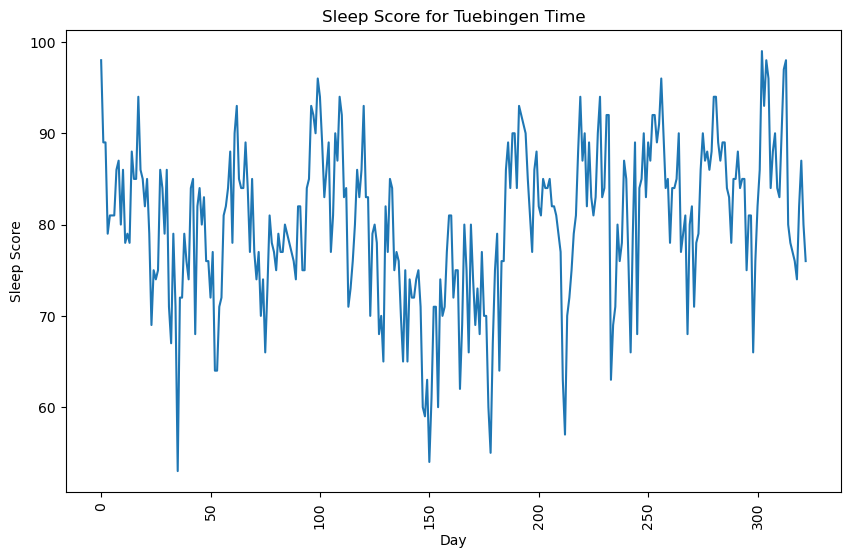

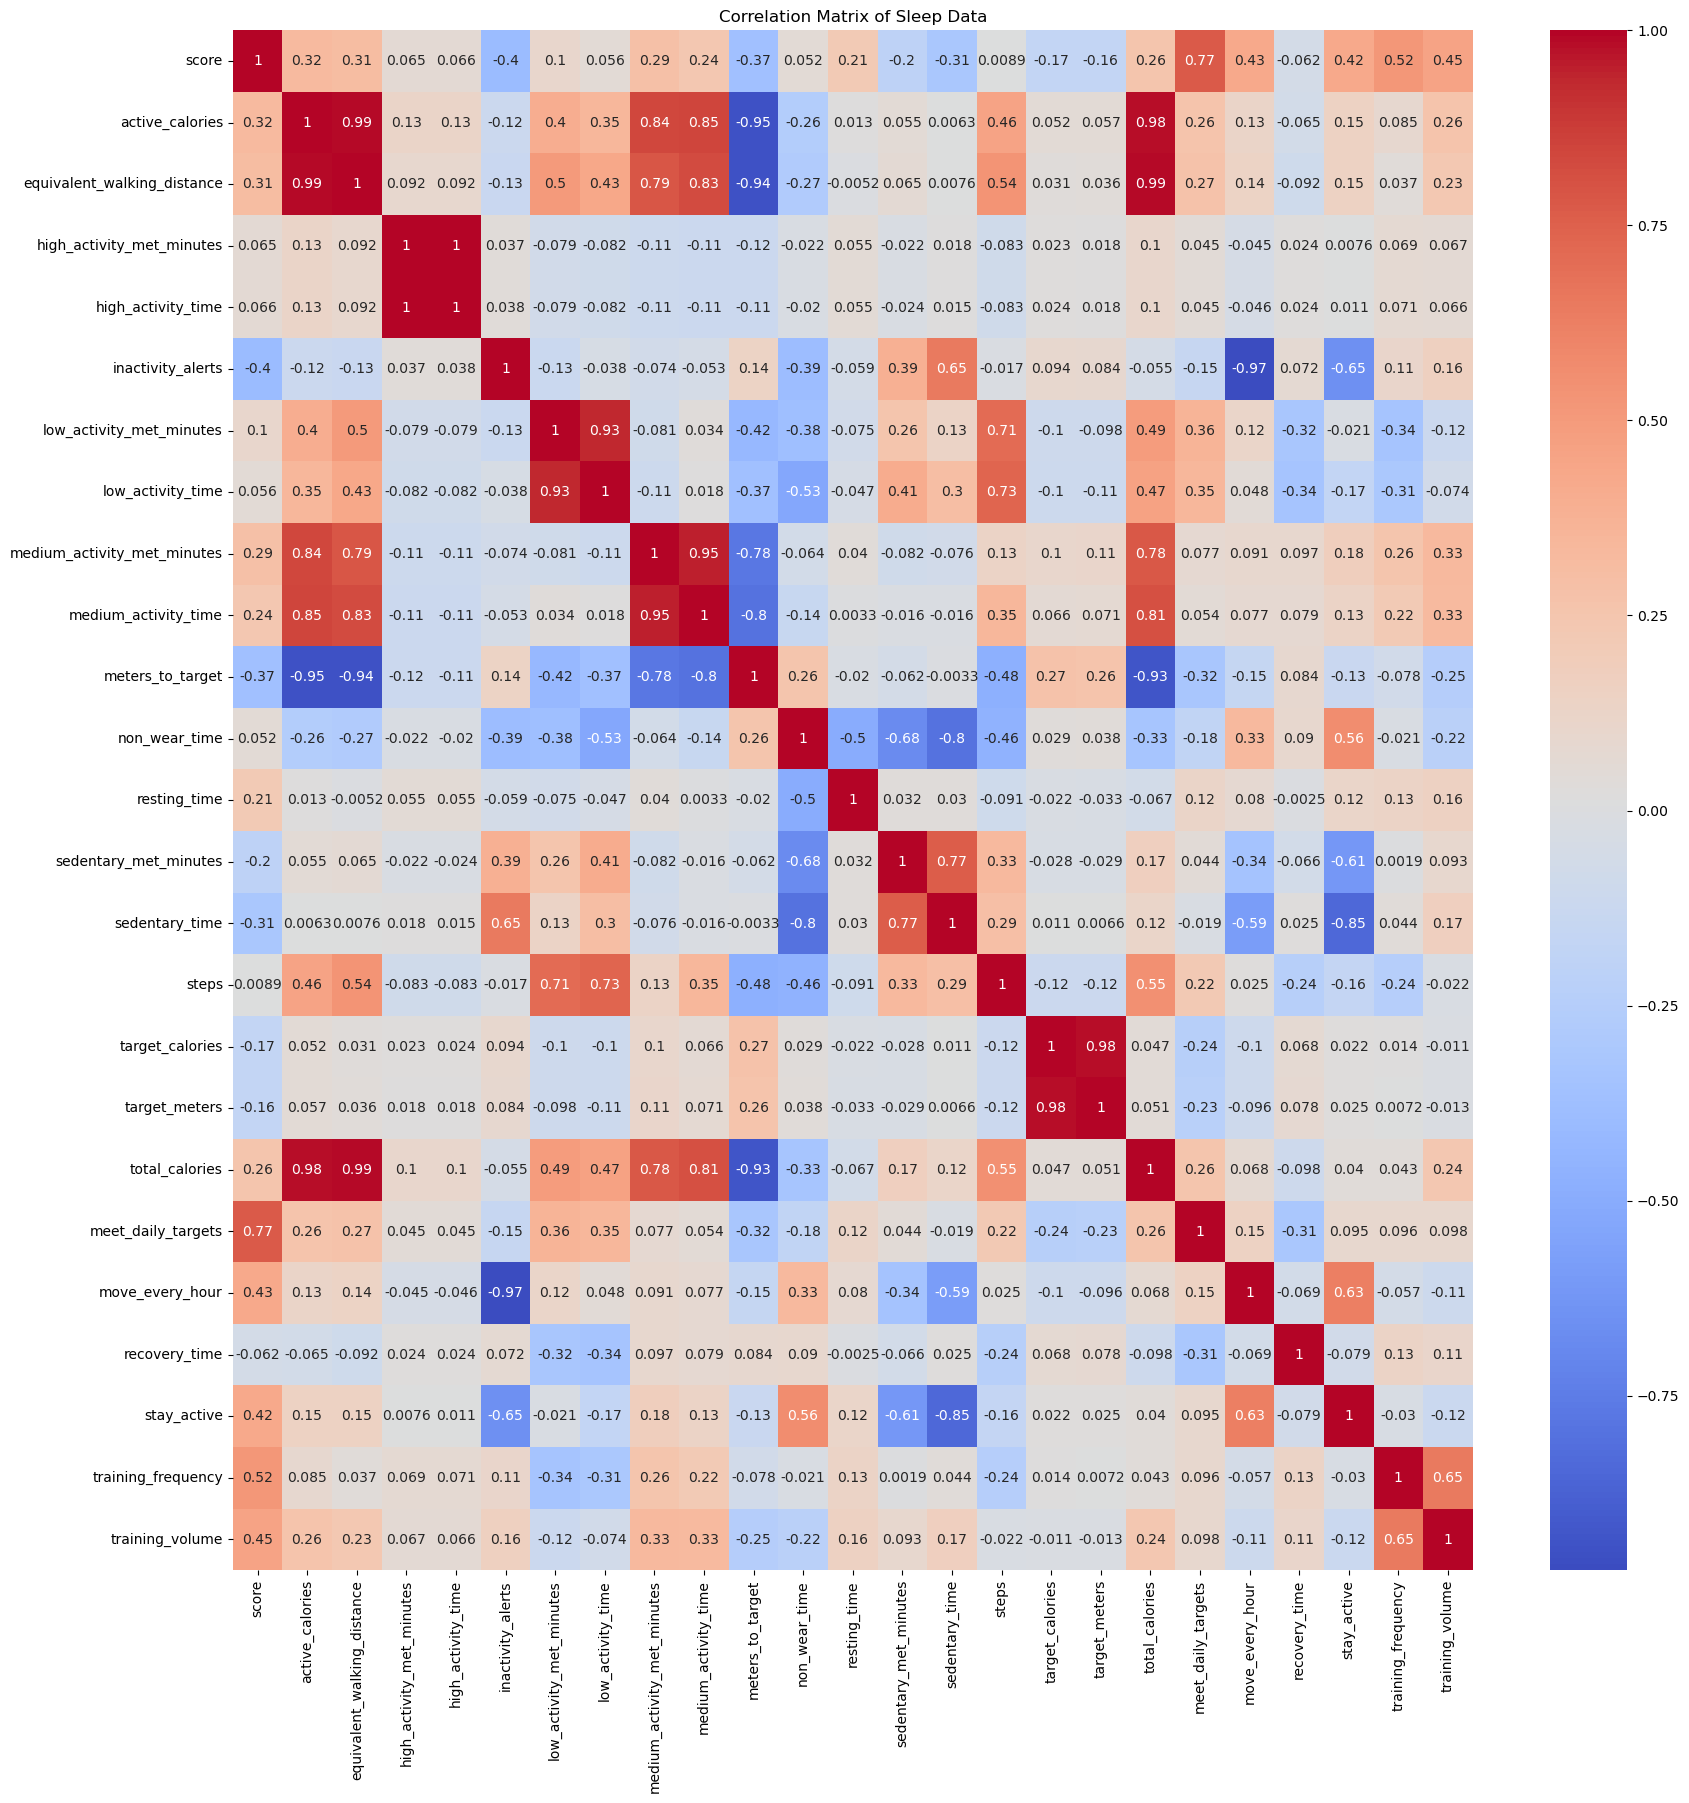

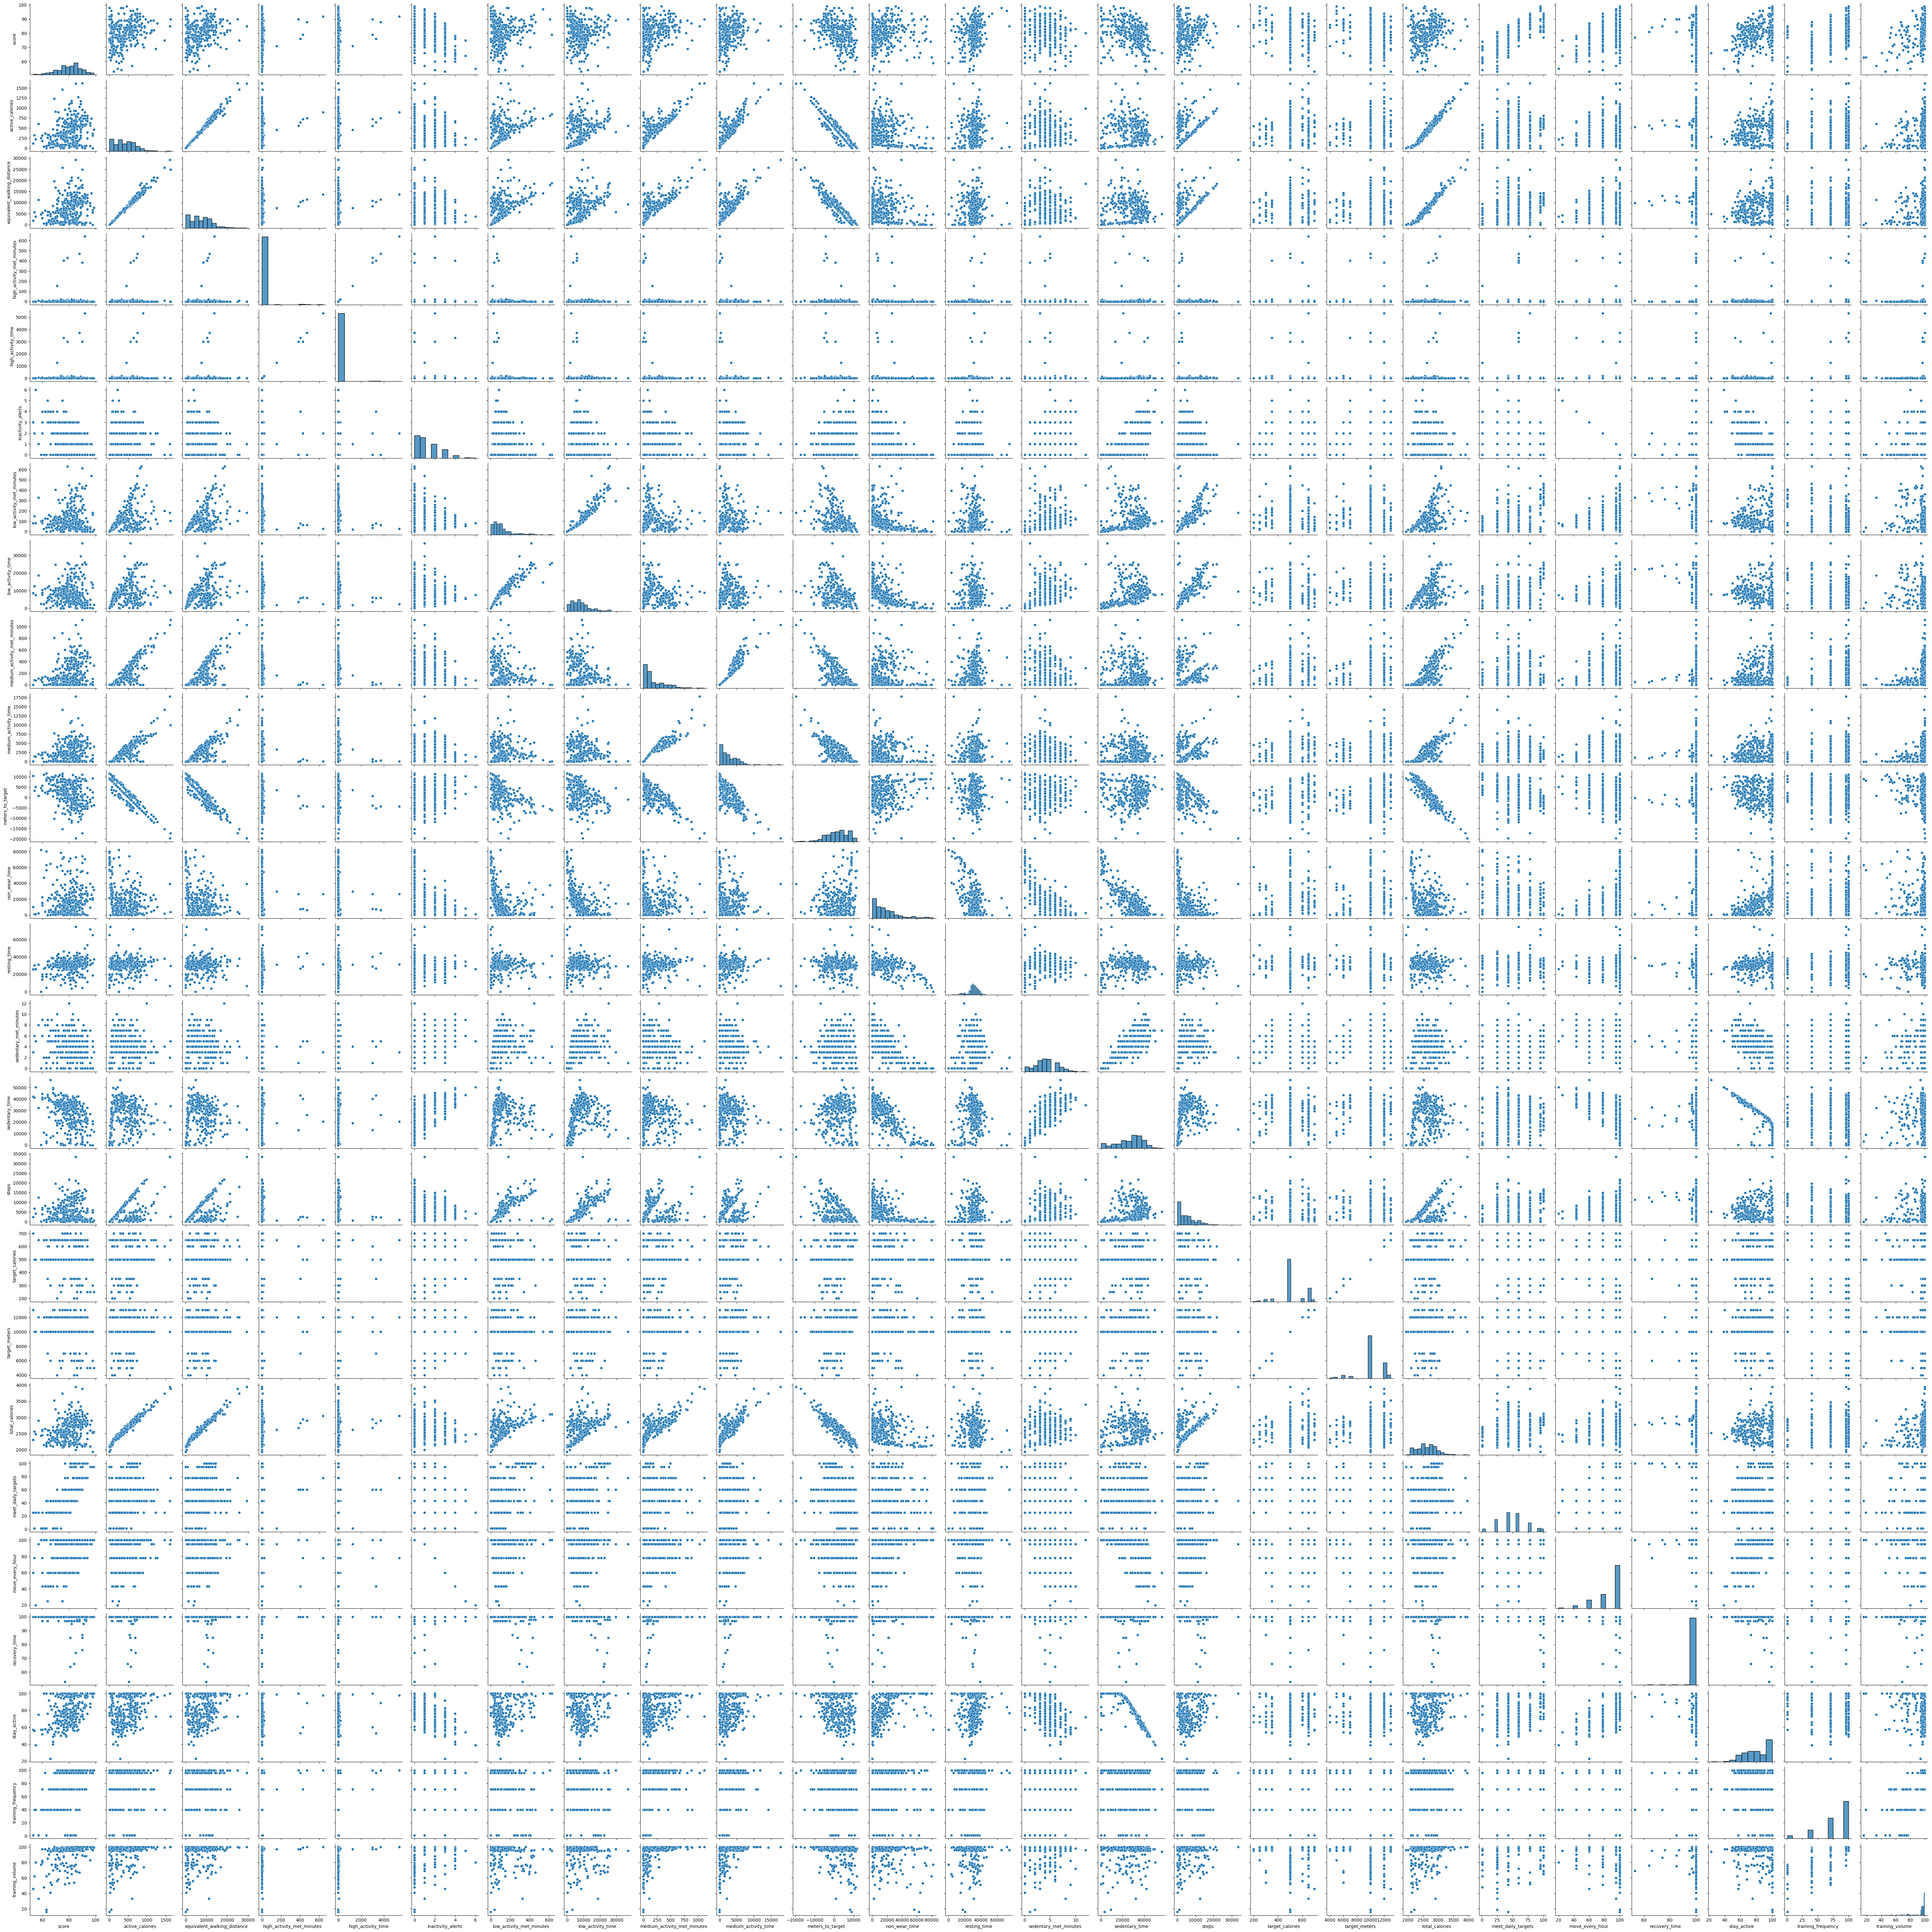

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(df_sleep.index, df_sleep.score)
plt.xticks(rotation=90);
plt.title("Sleep Score for Tuebingen Time")
plt.ylabel("Sleep Score")
plt.xlabel("Day")

#correlation matrix
correlation_matrix = df_sleep.select_dtypes(include="int").corr()
print(correlation_matrix)

#create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Sleep Data")
plt.show()

#pairplot
sns.pairplot(df_sleep.select_dtypes(include="int"))
plt.show()

# Getting Weather data in Tuebingen from OpenWeatherMap API

In [106]:
base_url = "https://api.openweathermap.org/data/2.5/weather?"
city_name = "Tuebingen"
api_key = open('openweather_key.txt').read()
url = base_url + "q=" + city_name + "&appid=" + api_key
# url = "https://api.openweathermap.org/data/2.5/weather?q=peshawar&appid=18094e6ef0c01ac87fb6e7716ae91836"
response = requests.get(url).json()
print(response)


{'coord': {'lon': 9.0522, 'lat': 48.5227}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'base': 'stations', 'main': {'temp': 293.04, 'feels_like': 293.1, 'temp_min': 292.14, 'temp_max': 294.18, 'pressure': 1013, 'humidity': 77, 'sea_level': 1013, 'grnd_level': 961}, 'visibility': 10000, 'wind': {'speed': 1.05, 'deg': 155, 'gust': 0.98}, 'clouds': {'all': 10}, 'dt': 1724181243, 'sys': {'type': 2, 'id': 19626, 'country': 'DE', 'sunrise': 1724127889, 'sunset': 1724178586}, 'timezone': 7200, 'id': 2820860, 'name': 'Tübingen', 'cod': 200}


# Get Historical Data for Dates in Oura Sleep Data

## Get Latitude and Longitude of City

In [326]:
# Base URL for the current weather data
base_url = "https://api.openweathermap.org/data/2.5/weather?"
city_name = "Tuebingen"
api_key = open('openweather_key.txt').read().strip()  # Ensure the API key is read correctly

# URL to get current weather data (including latitude and longitude)
url = base_url + "q=" + city_name + "&appid=" + api_key
response = requests.get(url).json()

# Extract latitude and longitude
lat = response['coord']['lat']
lon = response['coord']['lon']

print(f"Latitude: {lat}, Longitude: {lon}")


Latitude: 48.5227, Longitude: 9.0522


## Using the OpenWeatherMap API, get the historical weather data for a the specific location and timeframe

In [430]:
# Base URL for the One Call API
historical_url = "https://history.openweathermap.org/data/2.5/history/city?"

# Get the current year and month
# year = datetime.datetime.now().year
# month = datetime.datetime.now().month

# Loop through each day of the month
weather_data = []
for dt in df_sleep.unix_time:
    # Convert date to timestamp
    dt = int(dt)
    # Request historical data
    params = {
        'lat': lat,
        'lon': lon,
        'dt': dt,
        'appid': api_key,
        'units': 'metric'  # To get temperature in Celsius
    }
    response = requests.get(historical_url, params=params).json()
    weather_data.append(response)

    # To avoid hitting API limits, you may need to wait between requests
    time.sleep(1)

# Converting the Weather Data to a DataFrame

In [431]:
#Start a dataframe
weather_cols = ['dt','temp', 'feels_like', 'pressure', 'humidity','rain', 'snow', 'temp_min', 'temp_max', 'speed', 'deg', 'gust', 'all', 'id', 'main', 'description', 'icon']
weather_df = pd.DataFrame(columns=weather_cols)
 
#Populate weather_df with the values from the dictionary
#Loop over each day in the weather_data list
# Start an empty list to collect all rows
weather_data_rows = []
for day in weather_data:
    for i in range(0,2):
            weather_day = day['list'][i]
            dict_weather_items = {
                                    "dt": weather_day['dt'],
                                    "rain": weather_day.get('rain', {'1h': 0}).get('1h', 0),  # Check if 'rain' exists, assign value or 0
                                    "snow": weather_day.get('snow', {'1h': 0}).get('1h', 0)   # Check if 'snow' exists, assign value or 0
                                }
            dict_weather_items.update(weather_day['main'])
            dict_weather_items.update(weather_day['wind'])
            dict_weather_items.update(weather_day['clouds'])
            dict_weather_items.update(weather_day['weather'][0])

            # Append the dictionary to the list of rows
            weather_data_rows.append(dict_weather_items)

# Create a DataFrame from the list of rows
weather_df = pd.DataFrame(weather_data_rows, columns=weather_cols)
#Renaming df columns
weather_df.rename(columns={'all':'clouds', 'id':'weather_id', 'speed':'wind_speed', 'deg':'wind_deg', 'gust':'wind_gust', 'main':'weather_main', 'description':'weather_description', 'icon':'weather_icon'}, inplace=True)
#Adding a date column
weather_df['date'] = pd.to_datetime(weather_df['dt'], unit='s')


In [433]:
#Saving weather data from start_date='2024-09-01', end_date='2024-08-01'
# weather_df.to_csv(".data/oura_weather_data.csv", index=False)

# Loading saved sleep and weather data

In [3]:
weather_df = pd.read_csv("./data/oura_weather_data.csv")
df_sleep = pd.read_csv("./data/oura_sleep_data.csv")

In [25]:
weather_df.head()

dt   temp  feels_like  pressure  humidity  rain  snow  temp_min  \
0  1693526400  15.77       15.41      1016        77   0.0   0.0     13.93   
1  1693530000  15.95       15.59      1016        76   0.0   0.0     13.93   
2  1693612800  14.88       14.67      1019        86   0.0   0.0     14.26   
3  1693616400  14.44       14.19      1019        86   0.0   0.0     13.71   
4  1693699200  15.93       15.77      1023        84   0.0   0.0     14.82   

   temp_max  wind_speed  wind_deg  wind_gust  clouds  weather_id weather_main  \
0     16.25        2.55       203       5.07     100         804       Clouds   
1     16.44        2.65       207       4.20      90         804       Clouds   
2     15.25        1.12       187       1.19      69         803       Clouds   
3     14.77        1.01       186       1.03      98         804       Clouds   
4     16.59        1.17       202       1.13      17         801       Clouds   

  weather_description weather_icon                 date  
0     overcast clouds          04n  2023-09-01 00:00:00  
1     overcast clouds          04n  2023-09-01 01:00:00  
2       broken clouds          04n  2023-09-02 00:00:00  
3     overcast clouds          04n  2023-09-02 01:00:00  
4          few clouds          02n  2023-09-03 00:00:00

In [29]:
interested_cols = ['day','unix_time','score']
df_sleep[interested_cols]

day     unix_time  score
0    2023-09-01  1.693526e+09     98
1    2023-09-02  1.693613e+09     89
2    2023-09-03  1.693699e+09     89
3    2023-09-04  1.693786e+09     79
4    2023-09-05  1.693872e+09     81
..          ...           ...    ...
318  2024-07-27  1.722038e+09     74
319  2024-07-28  1.722125e+09     82
320  2024-07-29  1.722211e+09     87
321  2024-07-30  1.722298e+09     80
322  2024-07-31  1.722384e+09     76

[323 rows x 3 columns]

In [38]:
#Only considering the weather at midnight of each day
weather_midnight_df = weather_df[weather_df.index%2==0].copy()

In [49]:
#Merging the sleep and weather data
sleep_weather_df = pd.merge(df_sleep[interested_cols], weather_midnight_df, left_on='unix_time', right_on='dt', how='inner')
sleep_weather_df.drop(columns=['dt','date'], inplace=True)

In [50]:
sleep_weather_df.head()

day     unix_time  score   temp  feels_like  pressure  humidity  \
0  2023-09-01  1.693526e+09     98  15.77       15.41      1016        77   
1  2023-09-02  1.693613e+09     89  14.88       14.67      1019        86   
2  2023-09-03  1.693699e+09     89  15.93       15.77      1023        84   
3  2023-09-04  1.693786e+09     79  14.78       14.72      1027        92   
4  2023-09-05  1.693872e+09     81  16.06       15.68      1022        75   

   rain  snow  temp_min  temp_max  wind_speed  wind_deg  wind_gust  clouds  \
0   0.0   0.0     13.93     16.25        2.55       203       5.07     100   
1   0.0   0.0     14.26     15.25        1.12       187       1.19      69   
2   0.0   0.0     14.82     16.59        1.17       202       1.13      17   
3   0.0   0.0     13.58     15.25        1.16        64       1.48     100   
4   0.0   0.0     14.82     17.70        1.35        83       2.78      65   

   weather_id weather_main weather_description weather_icon  
0         804       Clouds     overcast clouds          04n  
1         803       Clouds       broken clouds          04n  
2         801       Clouds          few clouds          02n  
3         804       Clouds     overcast clouds          04n  
4         803       Clouds       broken clouds          04n

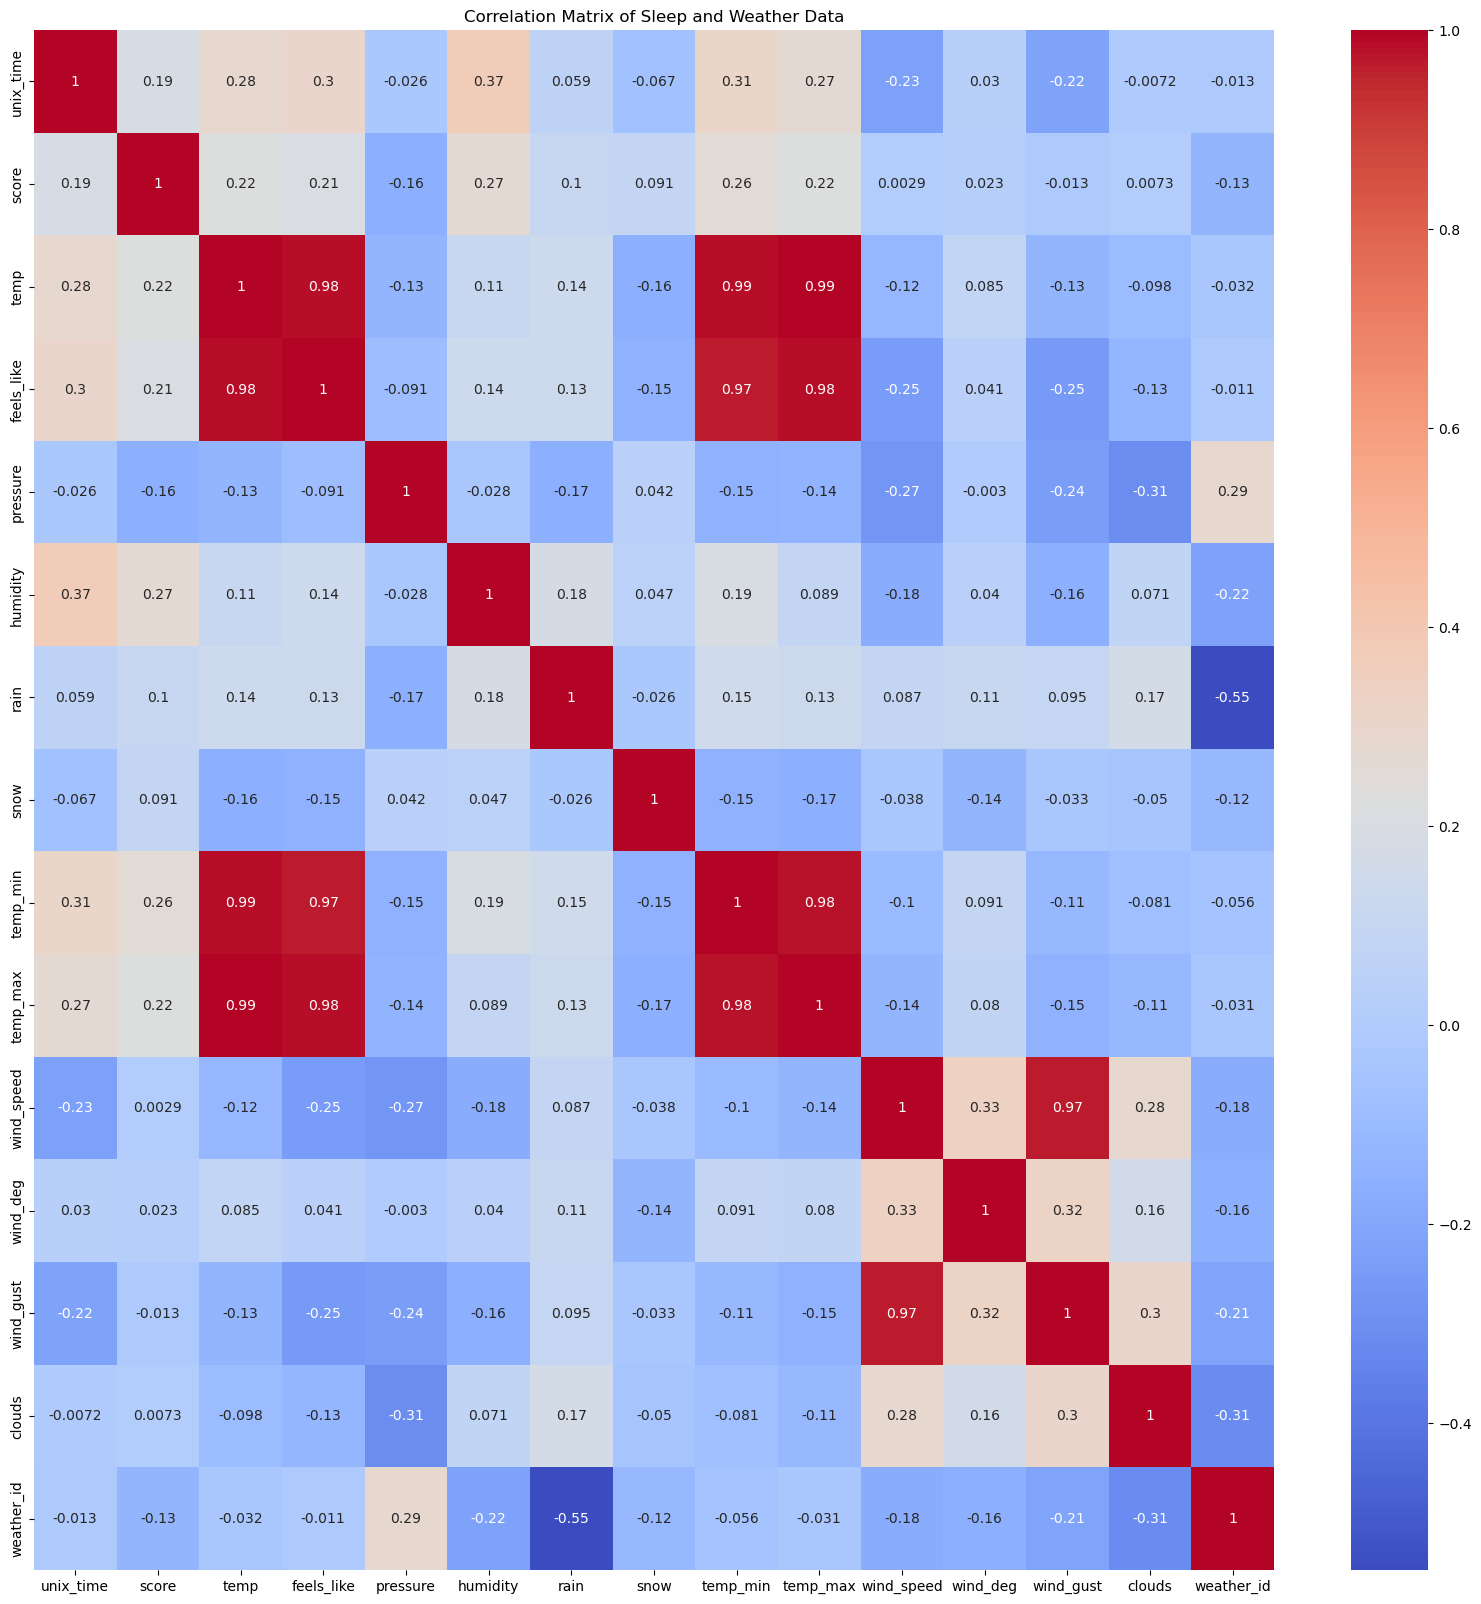

In [48]:
#Find correlation between score and other numerical variables
correlation_matrix = sleep_weather_df.select_dtypes(include=["int","float"]).corr()
# Display the correlation matrix

#create a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Sleep and Weather Data")
plt.show()

In [121]:
#Encoding the categorical columns
# Create a one-hot encoder
one_hot_encoder = pd.get_dummies(sleep_weather_df['weather_main'], prefix='weather_main', dtype='int')
# Concatenate the one-hot encoded columns to the DataFrame
sleep_weather_df = pd.concat([sleep_weather_df, one_hot_encoder], axis=1)

one_hot_encoder = pd.get_dummies(sleep_weather_df['weather_description'], prefix='weather_description',dtype='int')
# Concatenate the one-hot encoded columns to the DataFrame
sleep_weather_df = pd.concat([sleep_weather_df, one_hot_encoder], axis=1)

#Dropping unrelated columns
sleep_weather_df.drop(columns=['weather_id','weather_description','weather_icon','weather_main'], inplace=True)

#Renaming columns
sleep_weather_df.columns
sleep_weather_df = sleep_weather_df.rename(columns={
                                    "weather_main_Clear":"main_clear",
                                    "weather_main_Clouds":"main_clouds",
                                    "weather_main_Rain":"main_rain",
                                    "weather_main_Snow":"main_snow",
                                    "weather_description_broken clouds":"broken_clouds",
                                    "weather_description_clear sky":"clear_sky",
                                    "weather_description_few clouds":"few_clouds",
                                    "weather_description_intensity rain":"intensity_rain",
                                    "weather_description_light rain":"light_rain",
                                    "weather_description_light snow":"light_snow",
                                    "weather_description_moderate rain":"moderate_rain",
                                    "weather_description_heavy intensity rain":"heavy_intensity_rain",
                                    "weather_description_overcast clouds":"overcast_clouds",
                                    "weather_description_scattered clouds":"scattered_clouds"
                                 }
)

sleep_weather_df.head()

KeyError: "['weather_id', 'weather_description', 'weather_icon', 'weather_main'] not found in axis"

# Creating Training and Testing Data

In [94]:
#Creating Training and Test Sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Define the features and target variable
X = sleep_weather_df.drop(columns=['score','day','unix_time'])
y = sleep_weather_df['score']

#Scaling Features with MinMaxScaler
mm_scaler = MinMaxScaler()
X_scaled_array = mm_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=24)

In [200]:
from sklearn.metrics import mean_absolute_error

# Defining model training function

In [202]:
# Define model performance wrapper
def model_performance(models, X_train, X_test, y_train, y_test):
    results = {}
    n_models = len(models)
    n_cols = 2  # Number of columns for subplots
    n_rows = (n_models + n_cols - 1) // n_cols  # Calculate rows needed

    # Create a figure and axes for subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
    axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

    for i, (model_name, model) in enumerate(models):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Calculate scores
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        mae_test_score = mean_absolute_error(y_test, model.predict(X_test))

        # Print scores
        print(f"{model_name} Model Train Score (R^2):", train_score)
        print(f"{model_name} Model Test Score (R^2):", test_score)
        print(f"{model_name} MAE Test Score (MAE):", mae_test_score)

        # Store results
        results[model_name] = {
            'train_score': train_score,
            'test_score': test_score,
            'MAE_test': mae_test_score
        }

        # Make predictions
        y_pred = model.predict(X_test)

        # Plot the predicted and actual values
        axs[i].scatter(np.arange(len(y_test)), y_test, label="True Sleep Score", alpha=0.6)
        axs[i].scatter(np.arange(len(y_pred)), y_pred, label="Predicted Sleep Score", alpha=0.6)
        
        # Position legend in best location
        axs[i].legend(loc='best')
        axs[i].set_title(f"{model_name} Model Predictions")
        axs[i].set_xlabel("Sample Index")
        axs[i].set_ylabel("Sleep Score")
        

    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    # Create DataFrame from results
    results_df = pd.DataFrame(results).T 
    results_df = results_df.sort_values(by='test_score', ascending=False)
    return results_df

# Exploring baseline performances of different models

Linear Regression Model Train Score (R^2): 0.22138383072127255
Linear Regression Model Test Score (R^2): -0.03683887687483889
Linear Regression MAE Test Score (MAE): 6.208690053664114
Ridge Model Train Score (R^2): 0.1970048733076909
Ridge Model Test Score (R^2): 0.06825684996997006
Ridge MAE Test Score (MAE): 5.821896536836799
Lasso Model Train Score (R^2): 0.0
Lasso Model Test Score (R^2): -0.0006621527232415492
Lasso MAE Test Score (MAE): 6.3320214669051875
ElasticNet Model Train Score (R^2): 0.0
ElasticNet Model Test Score (R^2): -0.0006621527232415492
ElasticNet MAE Test Score (MAE): 6.3320214669051875
Decision Tree Model Train Score (R^2): 1.0
Decision Tree Model Test Score (R^2): -1.6422596793612572
Decision Tree MAE Test Score (MAE): 9.876923076923077
RandomForestRegressor Model Train Score (R^2): 0.8767392695058678
RandomForestRegressor Model Test Score (R^2): 0.04142101062987136
RandomForestRegressor MAE Test Score (MAE): 5.721384615384615
GradientBoostingRegressor Model Trai

/Users/marco/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork Model Train Score (R^2): -0.6063259065873663
NeuralNetwork Model Test Score (R^2): -1.1540445937664319
NeuralNetwork MAE Test Score (MAE): 9.170747077021465
SVR Model Train Score (R^2): 0.09778469336373141
SVR Model Test Score (R^2): 0.09277016220699152
SVR MAE Test Score (MAE): 5.911888286459057
KNN Model Train Score (R^2): 0.28321349590087685
KNN Model Test Score (R^2): 0.00909083708256786
KNN MAE Test Score (MAE): 6.304615384615384


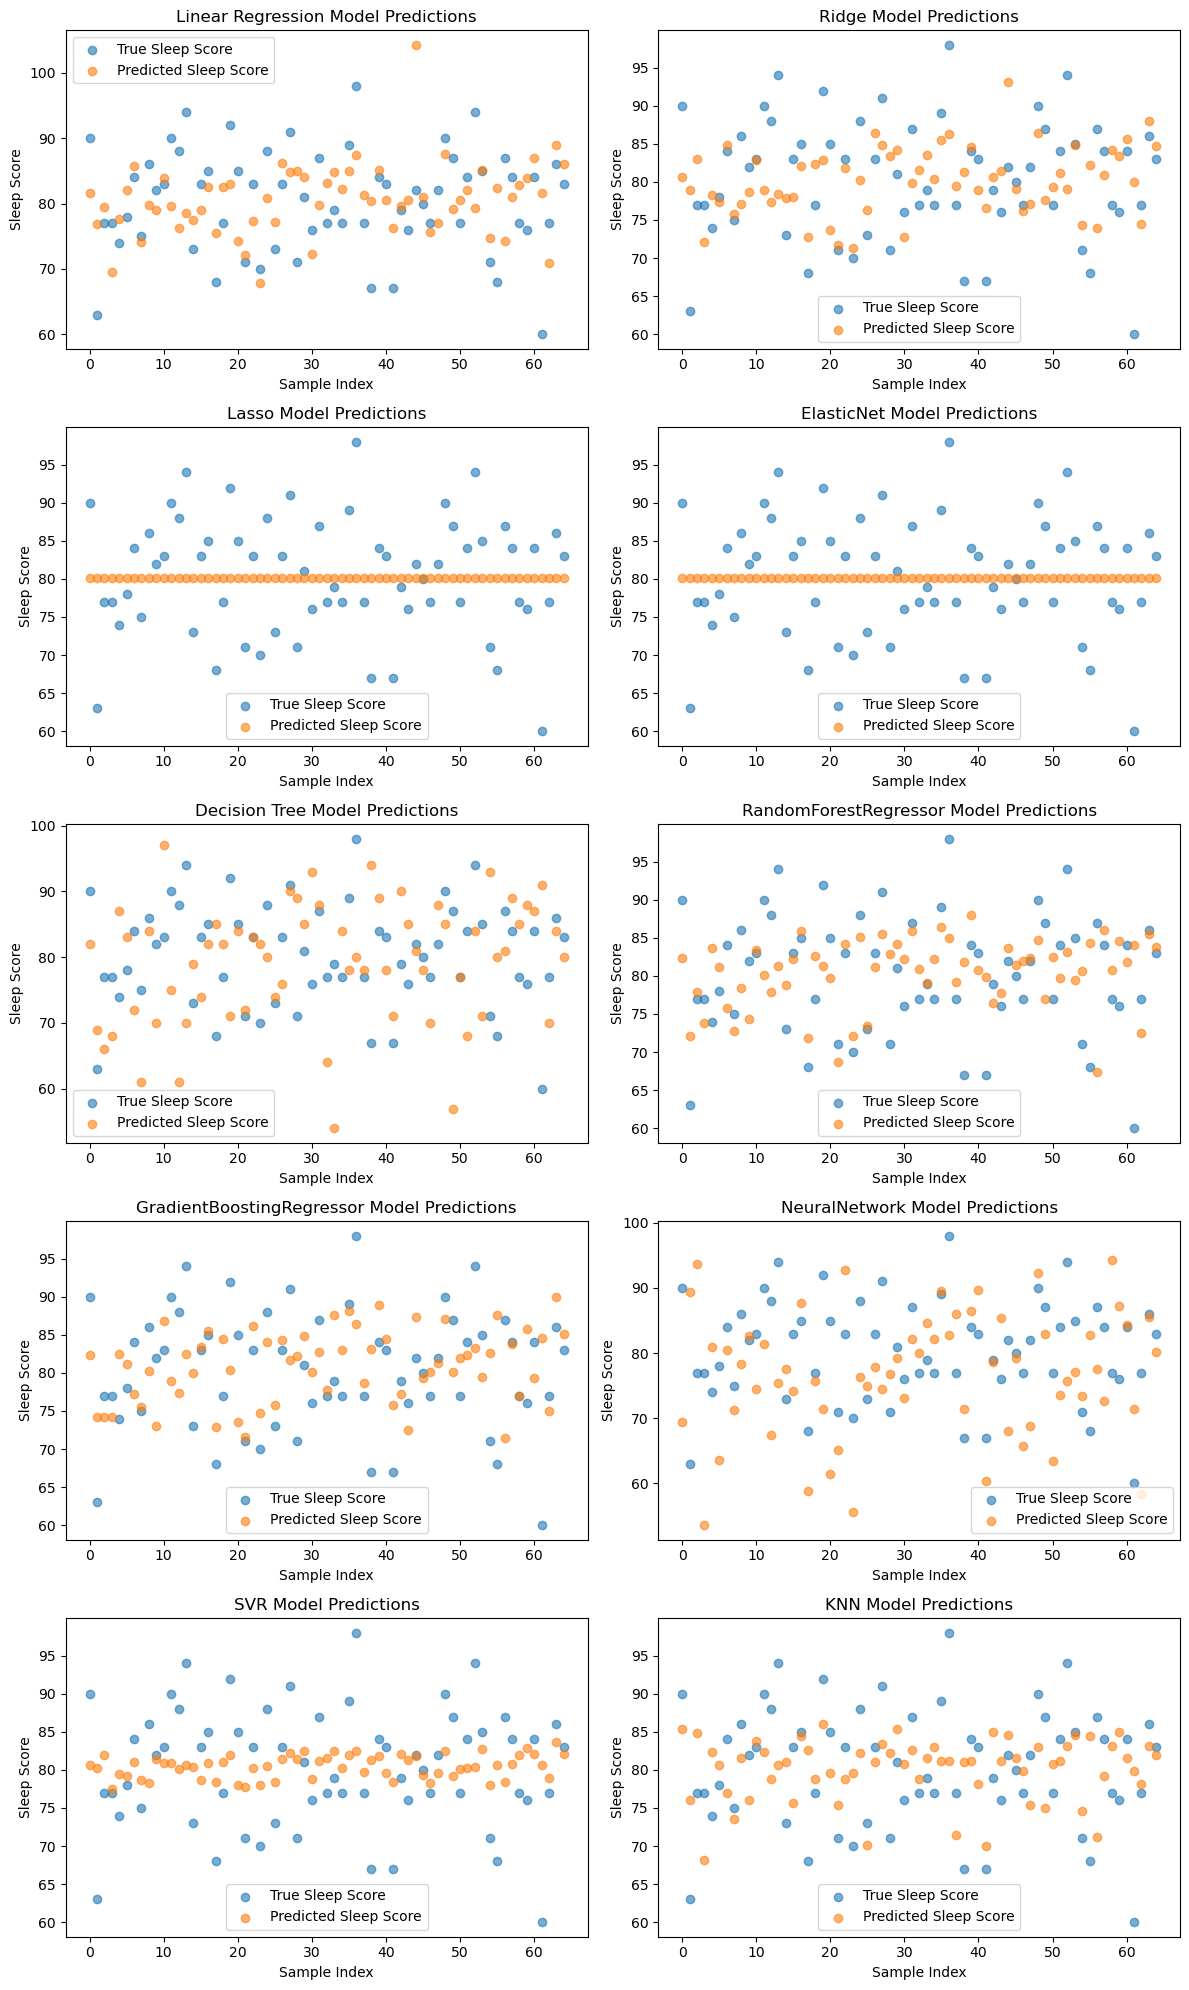

train_score  test_score  MAE_test
SVR                           0.097785    0.092770  5.911888
Ridge                         0.197005    0.068257  5.821897
RandomForestRegressor         0.876739    0.041421  5.721385
KNN                           0.283213    0.009091  6.304615
Lasso                         0.000000   -0.000662  6.332021
ElasticNet                    0.000000   -0.000662  6.332021
GradientBoostingRegressor     0.839493   -0.014914  6.008900
Linear Regression             0.221384   -0.036839  6.208690
NeuralNetwork                -0.606326   -1.154045  9.170747
Decision Tree                 1.000000   -1.642260  9.876923

In [203]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


# Define models in a list
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("ElasticNet", ElasticNet()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("GradientBoostingRegressor", GradientBoostingRegressor()),
    ("NeuralNetwork", MLPRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor())   
]

performance = model_performance(models, X_train, X_test, y_train, y_test)
performance

# All the models performanced poorly. Let's try to improve the model by selected only relevant features

In [182]:
from sklearn.feature_selection import SelectKBest, f_regression

In [187]:
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_scaled, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)

#create a new dataframe with the selected features
# Split the data into training and test sets
X_train_5, X_test_5, y_train, y_test = train_test_split(X_scaled[selected_features], y, test_size=0.2, random_state=24) #The row selection will remain the same as before cause random_state is the same



Selected Features: ['temp', 'feels_like', 'humidity', 'temp_min', 'temp_max']


Linear Regression Model Train Score (R^2): 0.16125938571008303
Linear Regression Model Test Score (R^2): 0.05293441865136039
Linear Regression MAE Test Score (MAE): 5.904250611505916
Ridge Model Train Score (R^2): 0.1362558858751427
Ridge Model Test Score (R^2): 0.06851252958645315
Ridge MAE Test Score (MAE): 5.817701979070208
Lasso Model Train Score (R^2): 0.0
Lasso Model Test Score (R^2): -0.0006621527232415492
Lasso MAE Test Score (MAE): 6.3320214669051875
ElasticNet Model Train Score (R^2): 0.0
ElasticNet Model Test Score (R^2): -0.0006621527232415492
ElasticNet MAE Test Score (MAE): 6.3320214669051875
Decision Tree Model Train Score (R^2): 1.0
Decision Tree Model Test Score (R^2): -1.085696407071795
Decision Tree MAE Test Score (MAE): 8.215384615384615
RandomForestRegressor Model Train Score (R^2): 0.8611082014258025
RandomForestRegressor Model Test Score (R^2): -0.05584354405614378
RandomForestRegressor MAE Test Score (MAE): 6.287538461538461
GradientBoostingRegressor Model Train

/Users/marco/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork Model Train Score (R^2): -11.356846517514855
NeuralNetwork Model Test Score (R^2): -16.80527337575711
NeuralNetwork MAE Test Score (MAE): 30.355247429847513
SVR Model Train Score (R^2): 0.13221422153676188
SVR Model Test Score (R^2): 0.07857330902732529
SVR MAE Test Score (MAE): 5.821356406022303
KNN Model Train Score (R^2): 0.3327755574030329
KNN Model Test Score (R^2): -0.034363316646600195
KNN MAE Test Score (MAE): 6.581538461538461


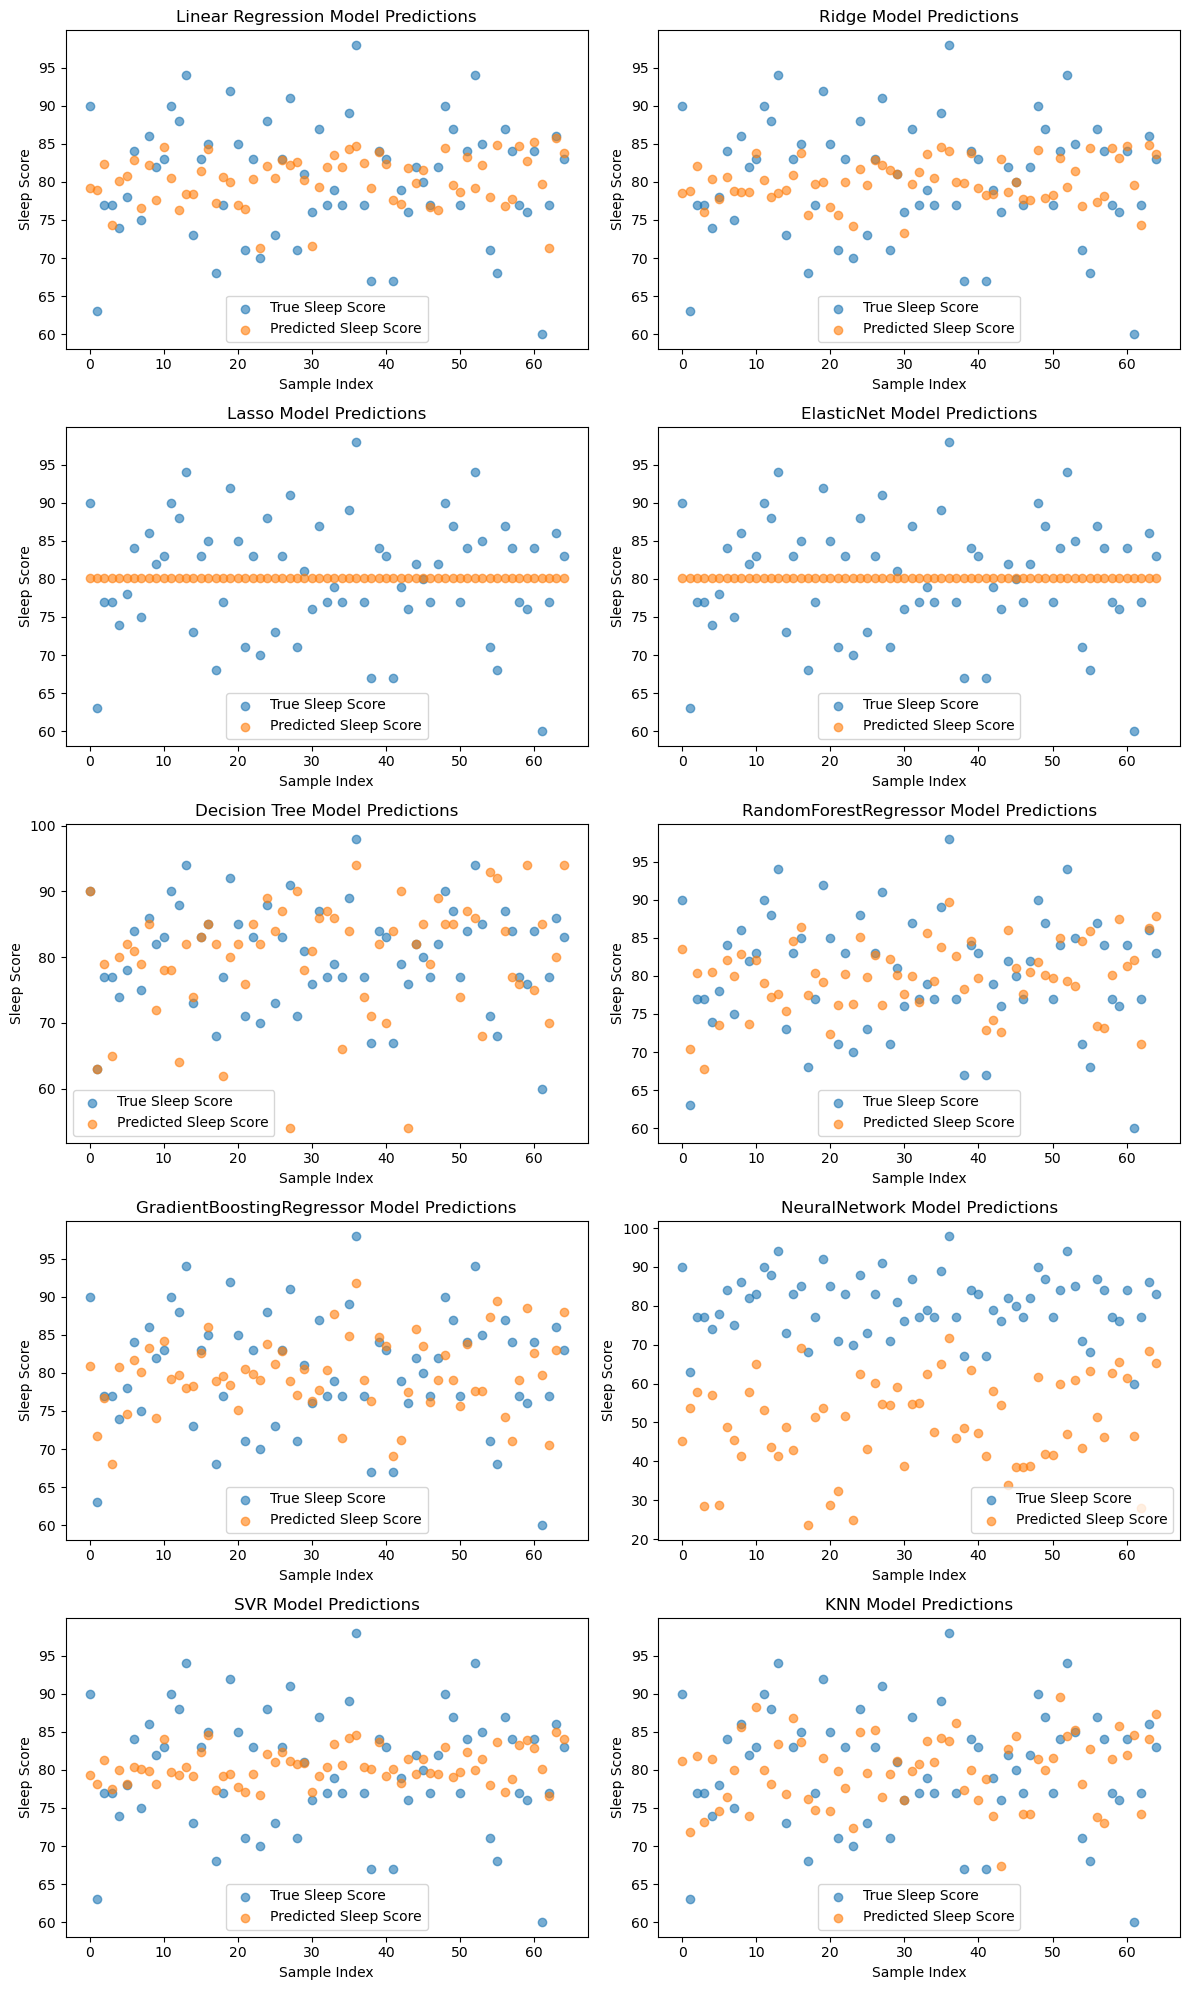

train_score  test_score   MAE_test
SVR                           0.132214    0.078573   5.821356
Ridge                         0.136256    0.068513   5.817702
Linear Regression             0.161259    0.052934   5.904251
Lasso                         0.000000   -0.000662   6.332021
ElasticNet                    0.000000   -0.000662   6.332021
KNN                           0.332776   -0.034363   6.581538
RandomForestRegressor         0.861108   -0.055844   6.287538
GradientBoostingRegressor     0.755078   -0.109574   6.385025
Decision Tree                 1.000000   -1.085696   8.215385
NeuralNetwork               -11.356847  -16.805273  30.355247

In [204]:
#Performance using the top 5 features
performance_5 = model_performance(models, X_train_5, X_test_5, y_train, y_test)
performance_5

In [213]:
#Compares the performance of the models with all features and the top 5 features
test_improvement = performance_5[['test_score','MAE_test']] - performance[['test_score','MAE_test']]

#Show improvement, ordered by the most decreases in MAE
test_improvement.sort_values(by='MAE_test', ascending=True)

test_score   MAE_test
Decision Tree                0.556563  -1.661538
Linear Regression            0.089773  -0.304439
SVR                         -0.014197  -0.090532
Ridge                        0.000256  -0.004195
ElasticNet                   0.000000   0.000000
Lasso                        0.000000   0.000000
KNN                         -0.043454   0.276923
GradientBoostingRegressor   -0.094660   0.376125
RandomForestRegressor       -0.097265   0.566154
NeuralNetwork              -15.651229  21.184500

# Conclusion for now: Using just the weather info at Midnight of the day of is not predictive of Oura Sleep Score
# Next: What are other Oura metrics?
# What are other weather metrics? -> More granular weather data e.g. hourly data?